In [169]:
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import skimage.feature

## Load Data

In [170]:
# classes:
# agricultural, airplane, baseball diamond, beach, buildings, chaparral,
# dense residential, forest, freeway, golf course, harbour, intersection, medium residential, mobile home park,
# overpass, parking lot, river, runway, sparse residential, storage tanks, tennis court

images = np.load("data/images.npy")
labels = np.load("data/labels.npy")

# resolution of an image without RGB value
resolution = images[0].shape[:2]

images_21 = images.copy()
images_5 = images.copy()[:500]   

labels_21 = labels.copy()       
labels_5 = labels.copy()[:500]       

# Data Preprocessing
Augment and split data

In [171]:
def preprocess(images, labels):
    X_train, y_train = images / 255.0, to_categorical(labels)   # normalise and convert to one hot
    
    # Data augmentation generator
    datagen = ImageDataGenerator(
        rotation_range=10,
        width_shift_range=0.1,        
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=False,
        fill_mode="nearest")

    datagen.fit(X_train)
    augmented_data = datagen.flow(X_train, y_train, batch_size=len(images))
    X_augmented, y_augmented = next(augmented_data)   # augmented_data is iterator, therefore apply next
    X_train = np.vstack((X_train, X_augmented))
    y_train = np.vstack((y_train, y_augmented))

    # Split the data
    X_train, _images, y_train, _labels = train_test_split(X_train, y_train, test_size=0.2, random_state=5)
    X_val, X_test, y_val, y_test = train_test_split(_images, _labels, test_size=0.5, random_state=5)

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train_21, X_val_21, X_test_21, y_train_21, y_val_21, y_test_21 = preprocess(images_21, labels_21)         # 21 classes    
X_train_5, X_val_5, X_test_5, y_train_5, y_val_5, y_test_5 = preprocess(images_5, labels_5)                 # 5 classes

def to_hog(data):
  data_hog = []

  for image in data:
    hog_features, _ = skimage.feature.hog(image, pixels_per_cell=[8,8], cells_per_block=[2,2], visualize=True,channel_axis=2)
    data_hog.append(hog_features)

  return np.array(data_hog)

## Visual Sample Predictions

In [172]:
def plot_predictions(model, images, labels, num_random_samples=100):
    num_random_samples = min(len(images), num_random_samples)                                       # if more samples requested than possible
    num_random_samples = 10 * (num_random_samples//10)                                              # because 10 images per row
    random_indices = np.random.choice(len(images), num_random_samples, replace=False)               # select 100 random images

    if isinstance(model, SVC):                                                                      # different prediction based on model
        y_pred = model.predict(to_hog(images[random_indices]))
    else:
        y_pred = np.argmax(model.predict(images[random_indices], verbose=0), axis=1)

    fig, axs = plt.subplots(int(num_random_samples/10), 10, figsize=(15, 15))                       # 10 images per row
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(f"Prediction on {num_random_samples} samples \n (red: wrong prediction, black: correct prediction)")

    correct_predictions = 0

    for i, idx in enumerate(random_indices):
        pred = y_pred[i] 
        true = labels[idx][0] if isinstance(model, SVC) else np.argmax(labels[idx])                 # categorical to actual class if CNN
        image = images[idx]
        row = i // 10
        col = i % 10

        if pred == true:  
            correct_predictions += 1
            colour = "black"
        else:
            colour = "red"

        axs[row, col].imshow(image)
        axs[row, col].set_title(f"T: {true}, P: {pred}", color=colour)                          
        axs[row, col].axis("off")

    plt.figtext(0.15, 0.1, f"Accuracy of {num_random_samples} samples: {correct_predictions/num_random_samples}")
    plt.show()

    return correct_predictions/num_random_samples

## Convolutional Neural Network (CNN)

Epoch 1/35
105/105 [==============================] - 4s 41ms/step - loss: 3.0304 - accuracy: 0.0533 - val_loss: 2.9917 - val_accuracy: 0.0952
Epoch 2/35
105/105 [==============================] - 4s 40ms/step - loss: 2.9106 - accuracy: 0.0926 - val_loss: 2.8516 - val_accuracy: 0.1048
Epoch 3/35
105/105 [==============================] - 4s 39ms/step - loss: 2.7301 - accuracy: 0.1256 - val_loss: 2.5600 - val_accuracy: 0.1357
Epoch 4/35
105/105 [==============================] - 4s 41ms/step - loss: 2.5548 - accuracy: 0.1420 - val_loss: 2.4078 - val_accuracy: 0.1619
Epoch 5/35
105/105 [==============================] - 4s 42ms/step - loss: 2.4352 - accuracy: 0.1786 - val_loss: 2.2331 - val_accuracy: 0.2071
Epoch 6/35
105/105 [==============================] - 4s 42ms/step - loss: 2.3316 - accuracy: 0.2000 - val_loss: 2.2835 - val_accuracy: 0.3048
Epoch 7/35
105/105 [==============================] - 4s 41ms/step - loss: 2.2152 - accuracy: 0.2438 - val_loss: 1.9753 - val_accuracy: 0.2786

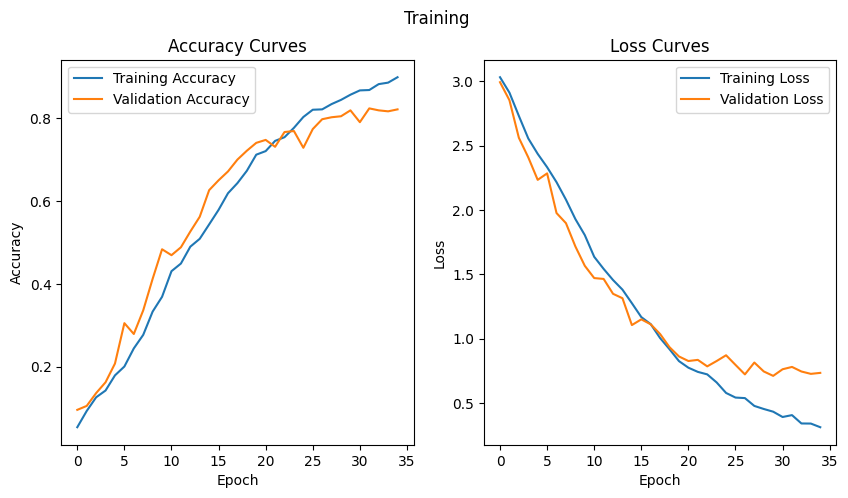

14/14 [==============================] - 0s 13ms/step - loss: 0.6481 - accuracy: 0.8214
Test Loss:  0.6480584740638733 | Test Accuracy:  0.8214285969734192
14/14 [==============================] - 0s 12ms/step
Test Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93        14
           1       0.92      0.96      0.94        23
           2       0.90      1.00      0.95         9
           3       0.94      0.94      0.94        17
           4       0.89      0.68      0.77        25
           5       0.92      1.00      0.96        23
           6       0.65      0.65      0.65        20
           7       0.91      0.91      0.91        22
           8       0.50      0.79      0.61        19
           9       0.81      0.85      0.83        20
          10       1.00      1.00      1.00        18
          11       0.76      0.57      0.65        23
          12       0.64      0.72      0.68        25
          13       1

<Figure size 1000x1000 with 0 Axes>

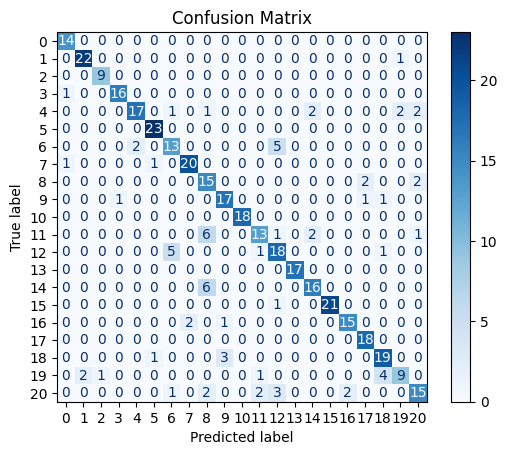

14/14 [==============================] - 0s 13ms/step - loss: 0.7340 - accuracy: 0.8214
Validation Loss:  0.7340120077133179 | Validation Accuracy:  0.8214285969734192
14/14 [==============================] - 0s 12ms/step


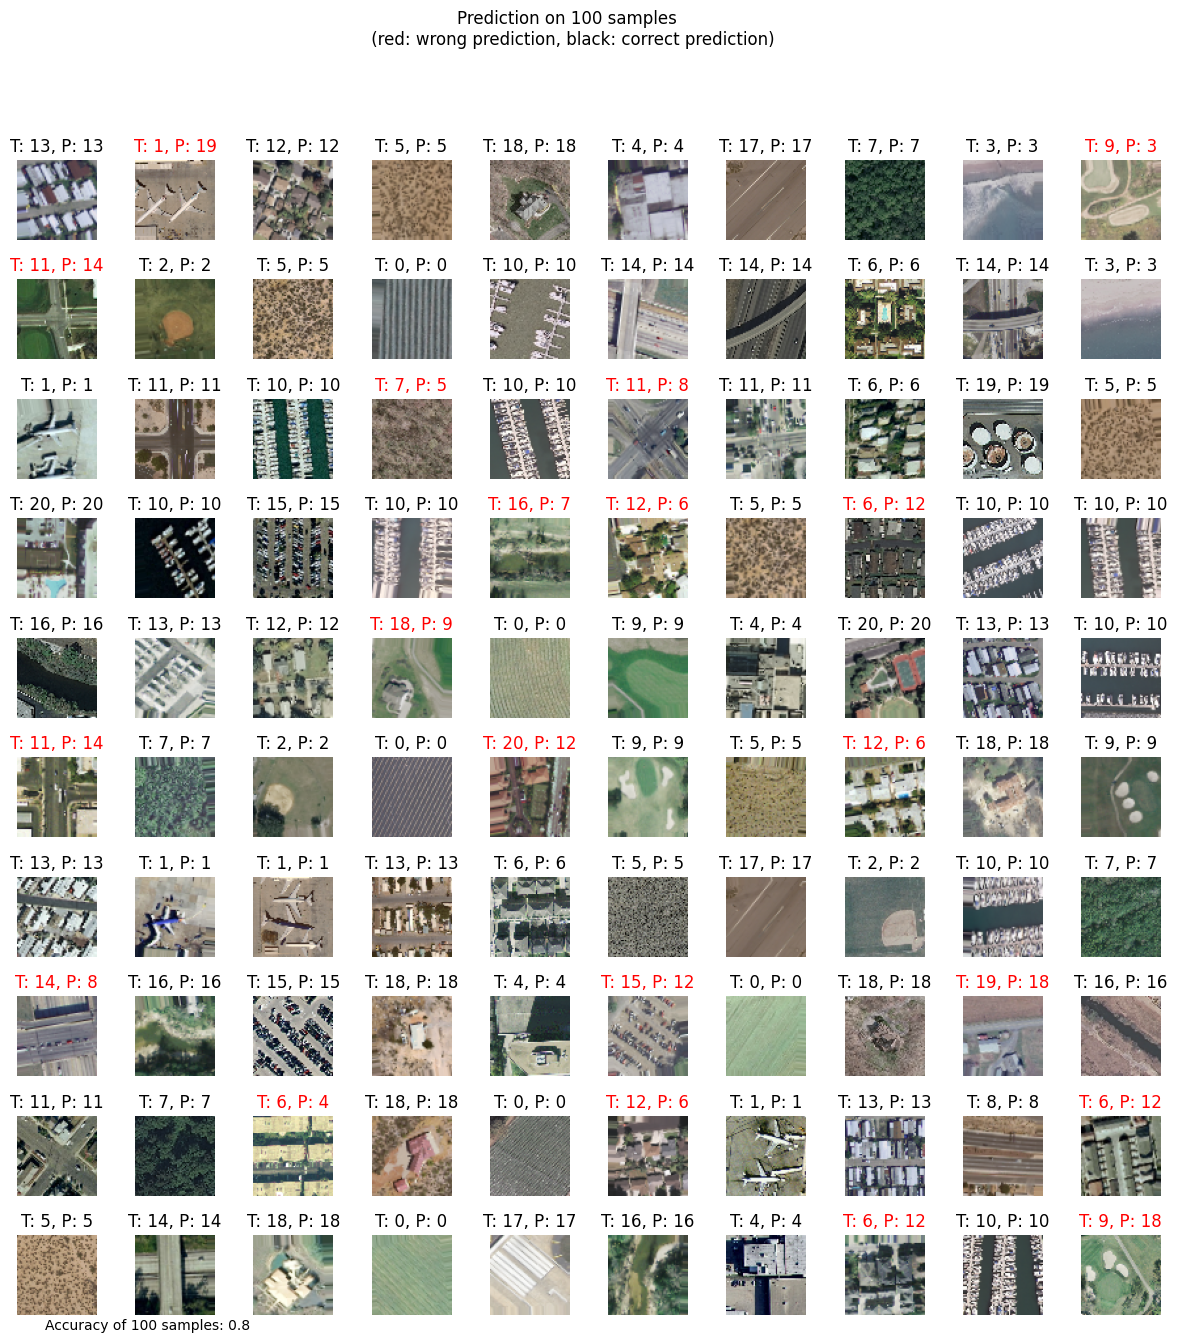

Prediction accuracy on these images:  0.8
Epoch 1/35
25/25 [==============================] - 1s 45ms/step - loss: 1.6121 - accuracy: 0.2025 - val_loss: 1.5225 - val_accuracy: 0.2600
Epoch 2/35
25/25 [==============================] - 1s 41ms/step - loss: 1.4618 - accuracy: 0.3225 - val_loss: 1.2780 - val_accuracy: 0.4500
Epoch 3/35
25/25 [==============================] - 1s 42ms/step - loss: 1.3285 - accuracy: 0.4375 - val_loss: 1.3175 - val_accuracy: 0.4200
Epoch 4/35
25/25 [==============================] - 1s 43ms/step - loss: 1.2119 - accuracy: 0.4762 - val_loss: 1.0662 - val_accuracy: 0.4700
Epoch 5/35
25/25 [==============================] - 1s 44ms/step - loss: 1.0657 - accuracy: 0.5263 - val_loss: 0.9646 - val_accuracy: 0.5500
Epoch 6/35
25/25 [==============================] - 1s 46ms/step - loss: 0.9650 - accuracy: 0.5562 - val_loss: 0.8640 - val_accuracy: 0.5600
Epoch 7/35
25/25 [==============================] - 1s 50ms/step - loss: 0.9044 - accuracy: 0.5875 - val_loss: 0

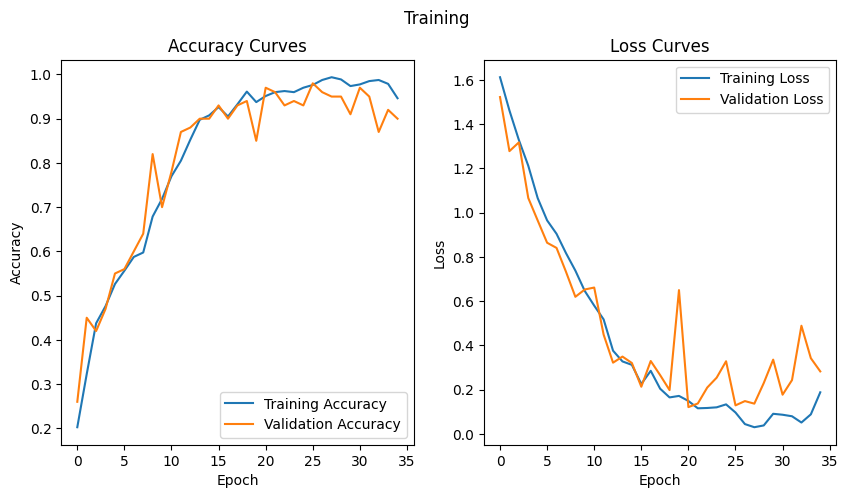

4/4 [==============================] - 0s 16ms/step - loss: 0.3957 - accuracy: 0.9200
Test Loss:  0.39574292302131653 | Test Accuracy:  0.9200000166893005
4/4 [==============================] - 0s 10ms/step
Test Report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        16
           1       0.91      0.83      0.87        12
           2       0.92      0.92      0.92        24
           3       0.97      1.00      0.99        33
           4       0.78      0.93      0.85        15

    accuracy                           0.92       100
   macro avg       0.91      0.90      0.90       100
weighted avg       0.93      0.92      0.92       100



<Figure size 1000x1000 with 0 Axes>

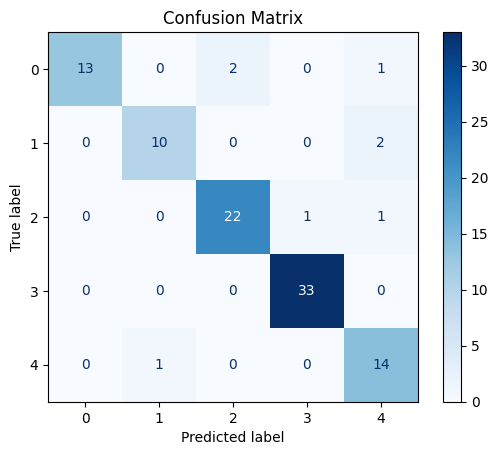

4/4 [==============================] - 0s 13ms/step - loss: 0.2825 - accuracy: 0.9000
Validation Loss:  0.2825251817703247 | Validation Accuracy:  0.8999999761581421
4/4 [==============================] - 0s 23ms/step


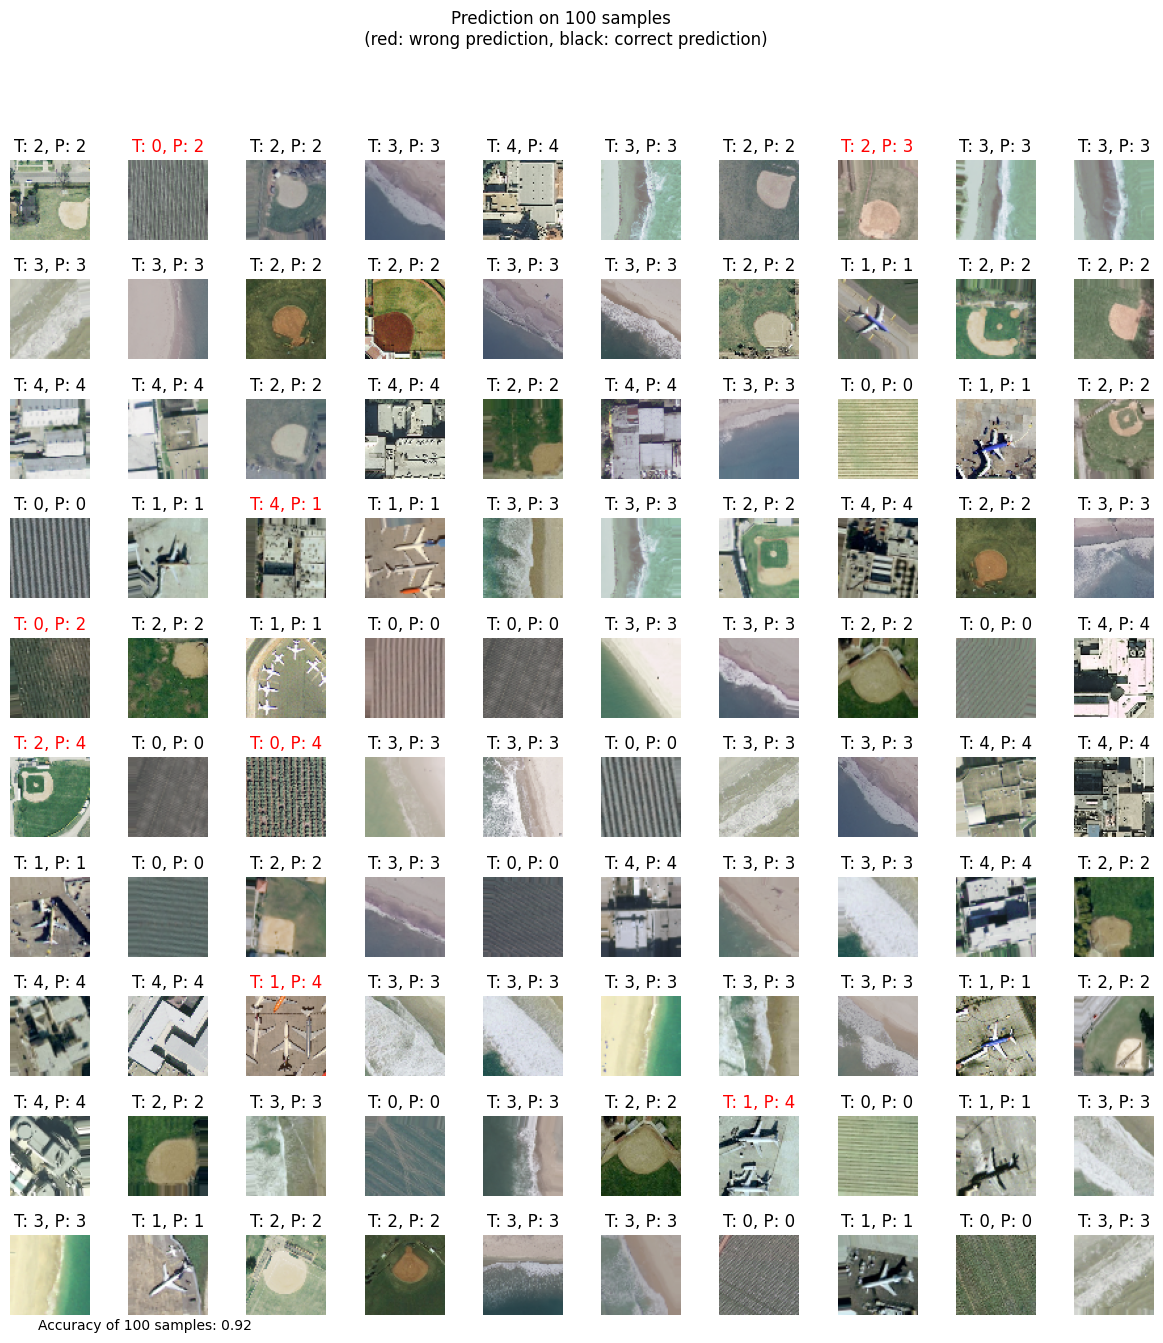

Prediction accuracy on these images:  0.92


In [173]:
def cnn(X_train, X_val, X_test, y_train, y_val, y_test):
    model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(resolution[0], resolution[1], 3), padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu", padding="same"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation="relu"),
    Dropout(0.7),
    Dense(128, activation="relu"),
    Dropout(0.65),
    Dense(len(y_train[0]), activation="softmax")
])

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    start = time.time()
    history = model.fit(X_train, y_train,
                        epochs=35,
                        validation_data=(X_val, y_val),
                        batch_size=32)
    end = time.time()

    print("Training runtime: ", end - start)

    # --- Training Evaluation ---
    plt.figure(figsize=[10,5])
    plt.suptitle("Training")
    plt.subplot(121)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training Accuracy",
            "Validation Accuracy"])
    plt.title("Accuracy Curves")

    plt.subplot(122)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training Loss",
            "Validation Loss"])
    plt.title("Loss Curves")
    plt.show()
    # ----------------------------

    # --- Test Evaluation ---
    loss, accuracy = model.evaluate(X_test, y_test)
    print("Test Loss: ", loss, "| Test Accuracy: ", accuracy)

    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)   

    test_report = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print("Test Report:")
    print(test_report)
    classes = np.unique(np.argmax(y_test, axis=1))  
    display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    plt.figure(figsize=(10, 10))
    display.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    # -----------------------

    # --- Validation Evaluation ---
    loss, accuracy = model.evaluate(X_val, y_val)
    print("Validation Loss: ", loss, "| Validation Accuracy: ", accuracy)

    y_pred = np.argmax(model.predict(X_val), axis=1)
    y_true = np.argmax(y_val, axis=1)
    # -----------------------------
    
    result = plot_predictions(model, X_test, y_test)   
    print("Prediction accuracy on these images: ", result)

cnn(X_train_21, X_val_21, X_test_21, y_train_21, y_val_21, y_test_21)   # all 21 classes
cnn(X_train_5, X_val_5, X_test_5, y_train_5, y_val_5, y_test_5)         # first 5 classes

## Support Vector Machine (SVM)

Training runtime:  0.5139009952545166
Test Accuracy:  0.81
Test Report:
              precision    recall  f1-score   support

           0       0.76      1.00      0.86        16
           1       0.54      0.58      0.56        12
           2       0.85      0.92      0.88        24
           3       0.93      0.76      0.83        33
           4       0.85      0.73      0.79        15

    accuracy                           0.81       100
   macro avg       0.78      0.80      0.78       100
weighted avg       0.82      0.81      0.81       100



<Figure size 1000x1000 with 0 Axes>

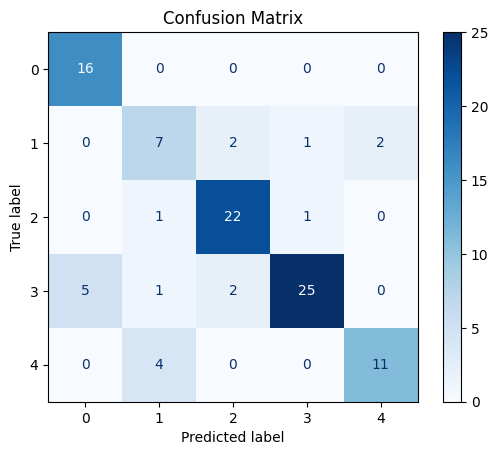

Validation Accuracy:  0.89


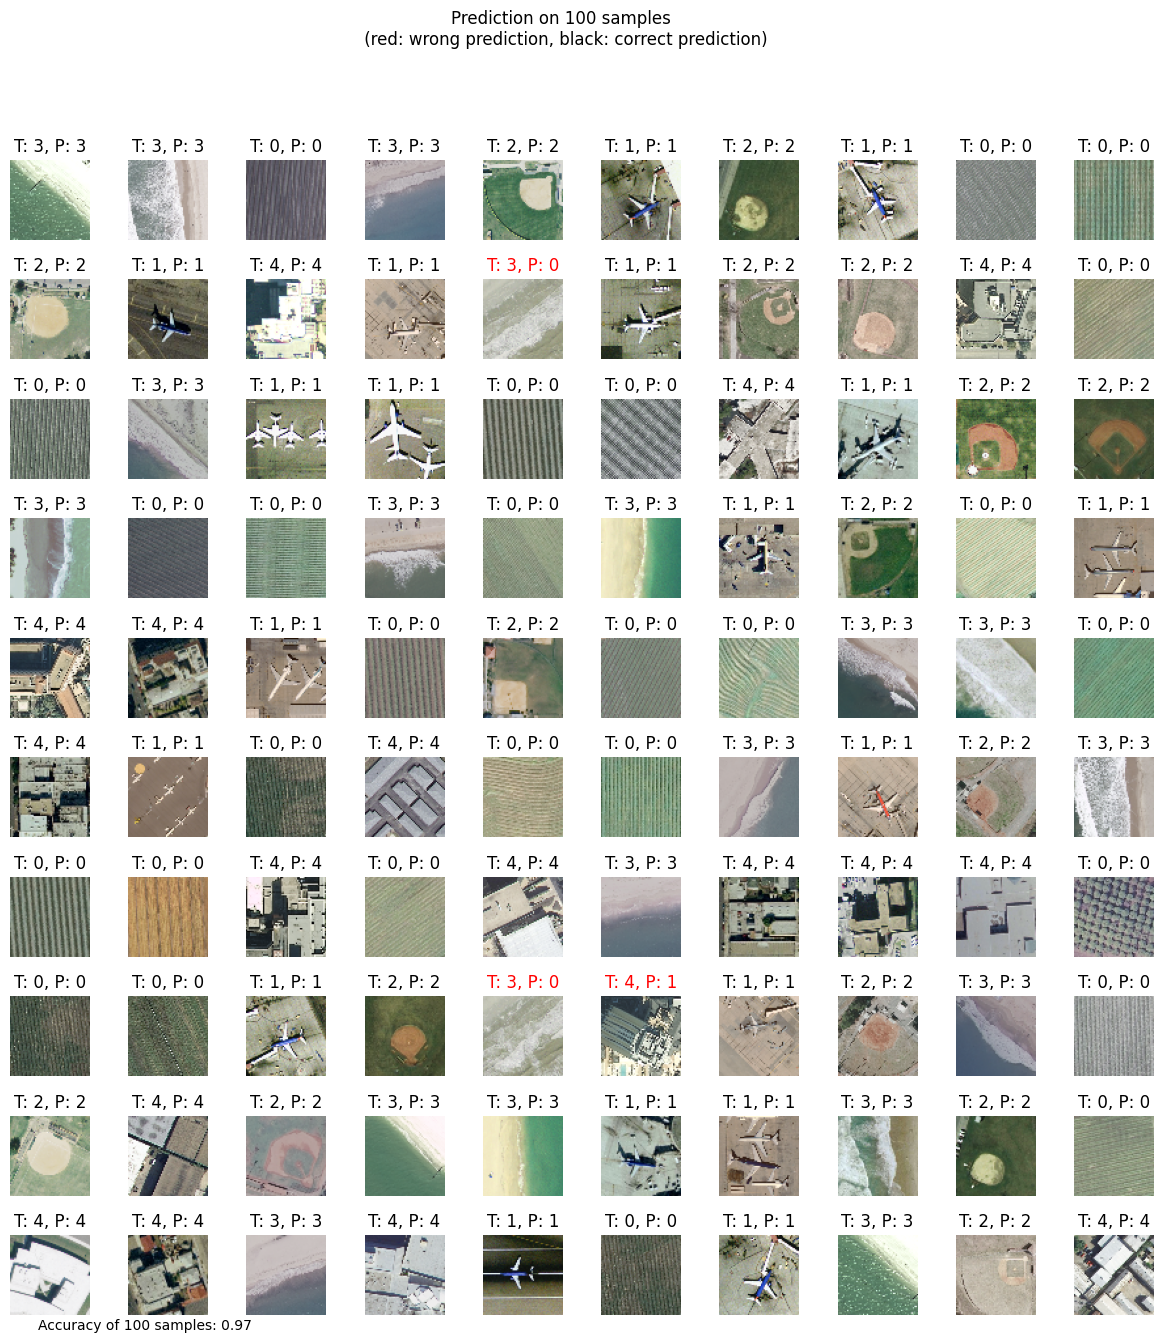

Prediction accuracy on these images:  0.97


In [174]:
model = SVC(kernel="rbf")

X_train_hog = to_hog(X_train_5)
X_val_hog = to_hog(X_val_5)
X_test_hog = to_hog(X_test_5)

start = time.time()
model.fit(X_train_hog, np.argmax(y_train_5, axis=1))            # np.argmax: back from categorical to actual class
end = time.time()
print("Training runtime: ", end - start)

# --- Test Evaluation ---
accuracy = model.score(X_test_hog, np.argmax(y_test_5, axis=1))  
print("Test Accuracy: ", accuracy)

y_pred = model.predict(X_test_hog)
cm = confusion_matrix(np.argmax(y_test_5, axis=1), y_pred)
test_report = classification_report(np.argmax(y_test_5, axis=1), y_pred)
print("Test Report:")
print(test_report)
classes = np.unique(np.argmax(y_test_5, axis=1))  
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
plt.figure(figsize=(10, 10))
display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
# -----------------------

# --- Validation Evaluation ---
accuracy = model.score(X_val_hog, np.argmax(y_val_5, axis=1))  
print("Validation Accuracy: ", accuracy)
# -----------------------------

result = plot_predictions(model, images_5, labels_5)
print("Prediction accuracy on these images: ", result)